In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy.linalg as LA
from IPython.display import Image
pd.set_option('display.max_rows', None)

## Rear Axel Bicycle Model

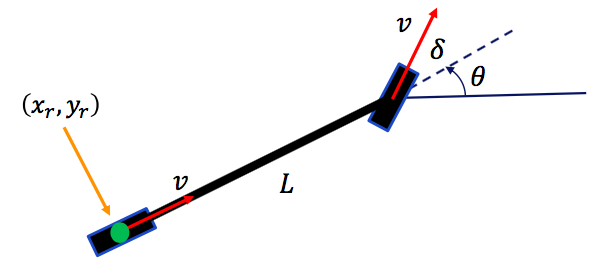

In [2]:
Image('rear_axle_bicycle_model.png', width=400)

### Transformation Class : Transformation for Visualization

In [3]:
class Transformation():
    # Transformation for drawing two wheels
    def convert_se2(self, p, theta):
        p = np.array(p)[:,None]
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c,-s],[s,c]])
        return np.block([[R, p],[np.zeros((1,2)), 1]])

    def invert_se2(self, T):
        theta = np.arctan2(T[1,0], T[0,0])
        p = T[:2, -1]
        return p, theta

In [205]:
class BicycleModel():
    L = 2
    T = 0.1
    def bicycle_model(self, state, v, gamma):
        #state : x, y, theta
        x, y, theta = state
        delta = np.array([v*np.cos(theta), v*np.sin(theta), v/self.L*np.tan(gamma)]) * self.T
        return state + delta

### Bicycle Class : Transformation + BicycleModel + Visualization

In [94]:
class Bicycle(Transformation, BicycleModel):
    wheel_len = 1
    wheel_width = 0.5
    
    def set_state(self, state, gamma):
        self.state = state
        self.gamma = gamma
    
    def show(self, ax=None):
        fig, ax = plt.subplots(figsize=[5,5])
        x, y, theta = self.state

        self.draw_wheel(self.state, fr='rear')
        self.draw_wheel(self.state, fr='front')

        plt.scatter(x, y, color='k')
        plt.axis([-5, 20, -5, 20])
        plt.grid()
    
    def draw_wheel(self, state, gamma=0, fr='rear'):
        ax = plt.gca()
        T_s_wheel = self.convert_se2(state[:2], state[2])
        if fr=='front':
            T_s_wheel = T_s_wheel @ self.convert_se2([self.L,0], 0) @ self.convert_se2([0,0], self.gamma)
        
        draw_pos = - np.array([self.wheel_len, self.wheel_width])/2
        T_wheel_draw = self.convert_se2(draw_pos[:2], 0)
        
        T_s_draw = T_s_wheel @ T_wheel_draw
        draw_xy, draw_theta = self.invert_se2(T_s_draw)
        wheel = patches.Rectangle(draw_xy, 
                                  self.wheel_len, self.wheel_width, 
                                  np.rad2deg(draw_theta), fc=None, ec='k', alpha=0.5)
        
        ax.add_patch(wheel)
        
        wheel_xy, wheel_theta = self.invert_se2(T_s_wheel)
        arrow_len = 1
        arrow_x, arrow_y = arrow_len * np.array([np.cos(wheel_theta), np.sin(wheel_theta)])
        ax.arrow(*wheel_xy, arrow_x, arrow_y, 
                 length_includes_head=True, head_width=0.3, head_length=0.5)
        
    def set_line(self, a, b, c):
        self.line_coeff = np.array([a, b, c])
        self.line = lambda x: -a*x/b - c/b

    def draw_line(self):
        ax = plt.gca()
        xx = np.arange(0,20,0.1)
        ax.plot(xx, self.line(xx), 'k--')
        plt.axis([0,20,0,20])
        plt.grid(True)
        
    def get_distance(self):
        line_coeff = self.line_coeff
        point = np.array(self.state[:2]+[1])
        return (line_coeff@point)/LA.norm(self.line_coeff[:2])

In [95]:
gamma_max = np.pi/4
def move_to_point_controller(state, ref, gain):
    pos_err = (ref[:2] - state[:2])
    theta_d = np.arctan2(pos_err[1], pos_err[0])
    theta_err = theta_d - state[2]
    v = LA.norm(pos_err) * gain[0]
    gamma = theta_err * gain[1]
    if abs(gamma) > gamma_max:
        gamma = np.sign(gamma)* gamma_max
    return v, gamma
    

In [186]:
gamma_max = np.pi/4
def path_following_controller(bicycle, gain):
    d = bicycle.get_distance()
    distance_control = - d * gain[0]
    
    convert_angle = lambda x: x if (-np.pi < x)&(x <= np.pi) else x - np.sign(x)*np.pi*2
    theta_d = np.arctan2(-1, -2)
    theta = bicycle.state[-1]
    theta_err = angle_func(theta_d-theta)
    heading_control = theta_err * gain[1]
    
    gamma = distance_control + heading_control
    if abs(gamma)>gamma_max: gamma = np.sign(gamma)*gamma_max
    return 1, gamma

### Initialize 

path : $x-2y+3=0$

In [255]:
states = ['x','y','theta']
sim = pd.DataFrame(columns=states)
sim.loc[0,states] = start
bicycle = Bicycle()

In [256]:
a, b, c = [1, -2, 3]
bicycle.set_line(a, b, c)

In [257]:
start = [18,16,4]

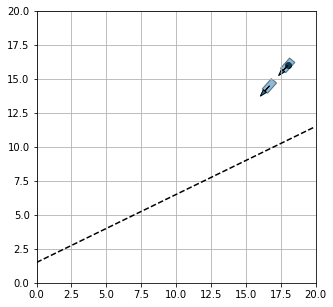

In [258]:
bicycle.set_state(start, 0)
bicycle.show()
bicycle.draw_line()

In [259]:
states = ['x','y','theta']
sim = pd.DataFrame(columns=states)
sim.loc[0,states] = start

In [260]:
curr_state = sim.loc[0,states]
for i in range(200):
    gain = [0.5, 2]
    v, gamma = path_following_controller(bicycle, gain)
    next_state = bicycle.bicycle_model(bicycle.state, v, gamma)
    
    curr_state = next_state.tolist()
    bicycle.set_state(curr_state, gamma)
    
    # update
    idx = len(sim)
    sim.loc[idx,states] = next_state
    sim.loc[idx, 'v'] = v
    sim.loc[idx, 'gamma'] = gamma
    
final_state = next_state
sim;

### Visualization 

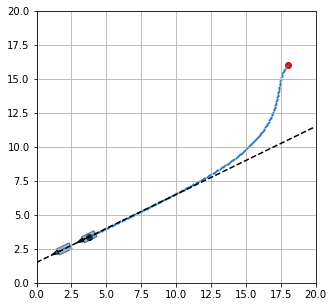

In [261]:
bicycle.show()
bicycle.draw_line()
plt.scatter(*start[:2], color='r')
plt.scatter(sim.loc[:i,'x'], sim.loc[:i,'y'], s=1);

### draw animation 

In [262]:
from PIL import Image as PILImage
import io
def make_snapshot(close=True):
    fig = plt.gcf()
    buffer = io.BytesIO()        
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    im = PILImage.open(buffer)
    if close==True:
        plt.close()
    return im

In [269]:
ims = []
for i, row in sim.iterrows():
    state = row.loc[['x','y','theta']].to_numpy()
    gamma = row.loc['gamma']
    bicycle.set_state(state, gamma)
    bicycle.show();
    plt.scatter(sim.loc[:i,'x'], sim.loc[:i,'y'], s=1)
    plt.scatter(*start[:2], color='r')
    bicycle.draw_line()
    ims.append(make_snapshot())

In [270]:
ims[0].save('out_path_following.gif', format='GIF',append_images=ims[1:], save_all=True, duration=100, loop=0)

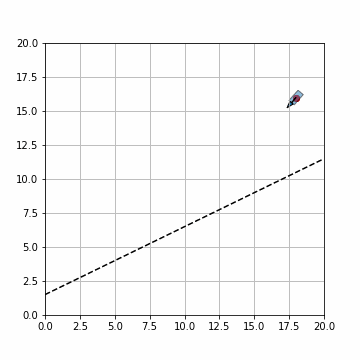

In [271]:
Image('out_path_following.gif', width=400)